# Introduction to sensAI: Supervised Learning with VectorModels

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../src")

import sensai
import numpy as np

## Logging

sensAI will log relevant activies and inform about ongoing processes as well as results via the log. It is therefore highly recommended that logging be enabled when using sensAI.

sensAI provides a `logging` module which includes Python's standard logging module and adds some additional functionality. To enable logging, simply use its `configureLogging` function.


In [3]:
from sensai.util import logging

logging.configure(level=logging.INFO)

To additionally write log output to a file, use the function `logging.add_file_logger`.

## VectorModels

The central base class for supervised learning problems in sensAI is `VectorModel`. A VectorModel is any model which operates on data points that can be reprsented as vectors of data. Here, vector is to be understood not in the mathematical sense but in the computer science sense, where a vector is simply an array of (potentially arbitaririly complex) data. (The mathematical equivalent is a tuple.) Models are typically expected to be able to process more than one data point at a time and thus should be able to process a sequence of vectors. 

We use pandas DataFrames to represent such sequences of data points. Note that pandas DataFrames are not limited to primitive data types but can hold arbitrary objects in every cell. When dealing with a large number of inputs, DataFrames also provide at least limited meta-information in the form of column names, so we do not lose track of what is contained in which element of a data point (vector).

VectorModel itself is an abstract base class, which provides a lot of useful functionality that all its specialisations inherit (as we will see later, particularly in the more advanced tutorials). The class is specialised in `VectorClassificationModel` and `VectorRegressionModel`, which in turn are specialised for various machine learning frameworks (such as sklearn and PyTorch) or can be directly subclassed to create your own model. 

In this tutorial, we will be dealing with a classification problem. Therefore, we will apply subclasses of `VectorClassificationModel` such as `SkLearnRandomForestVectorClassificationModel`. As an sklearn classification model which uses a well-defined training and inference interface, the implementation of the class is essentially justa few lines of code (given the intermediate abstraction `AbstractSkLearnVectorClassificationModel` for all classification models that use the sklearn protocol).

## Training and Evaluating Models

First, let us load a dataset which we can experiment. sklearn provides, for example, the Iris classification dataset, where the task is to differentiate three different types of flowers based on measurements of their petals and sepals.

In [4]:
import sklearn.datasets
import pandas as pd

iris_data = sklearn.datasets.load_iris()
iris_input_df = pd.DataFrame(iris_data["data"], columns=iris_data["feature_names"]).reset_index(drop=True)
iris_output_df = pd.DataFrame({"class": [iris_data["target_names"][idx] for idx in iris_data["target"]]}).reset_index(drop=True)

Here's a sample of the data, combining both the inputs and outputs:

In [5]:
iris_combined_df = pd.concat((iris_input_df, iris_output_df), axis=1)
iris_combined_df.sample(10)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class
43,5.0,3.5,1.6,0.6,setosa
61,5.9,3.0,4.2,1.5,versicolor
98,5.1,2.5,3.0,1.1,versicolor
52,6.9,3.1,4.9,1.5,versicolor
47,4.6,3.2,1.4,0.2,setosa
5,5.4,3.9,1.7,0.4,setosa
104,6.5,3.0,5.8,2.2,virginica
128,6.4,2.8,5.6,2.1,virginica
18,5.7,3.8,1.7,0.3,setosa
124,6.7,3.3,5.7,2.1,virginica


When working with sensAI, we typically use DataFrames such as this as the starting point.

We create an instance of **InputOutputData** from the two data frames.

In [6]:
iris_io_data = sensai.InputOutputData(iris_input_df, iris_output_df)

### Low-Level Training and Inference 

We use a **DataSplitter** (see subclasses) to split the data into a training and test set, specifically a **DataSplitterFractional**.

In [7]:
data_splitter = sensai.data.DataSplitterFractional(0.8, shuffle=True)
training_io_data, test_io_data = data_splitter.split(iris_io_data)

Now we are ready to train a model. Let us train a random forest classifier, which should work well for this sort of problem. sensAI provides models from various libraries, including scikit-learn, PyTorch, lightgbm, xgboost, catboost, and TensorFlow.

In this case, let us use the random forest implementation from sklearn, which is provided via the wrapper class SkLearnRandomForestVectorClassificationModel.

sensAI's **VectorModel** classes (specialised for classification and regression) provide a common interface with a lot of useful functionality, which we will see later.

In [8]:
random_forest_model = sensai.sklearn.classification.SkLearnRandomForestVectorClassificationModel(
    min_samples_leaf=2).with_name("RandomForest")

The class suppports all the parameters supported by the original sklearn model. In this case, we only set the minimum number of samples that must end up in each leaf.

We train the model using the `fitInputOutputData` method; we could also use the `fit` method, which is analogous to the sklearn interface and takes two arguments (input, output).

In [9]:
random_forest_model.fit_input_output_data(training_io_data)
random_forest_model

INFO  2024-11-29 18:24:24,463 sensai.vector_model:fit:359 - Fitting SkLearnRandomForestVectorClassificationModel instance


INFO  2024-11-29 18:24:24,464 sensai.sklearn.sklearn_base:_fit_classifier:314 - Fitting sklearn classifier of type RandomForestClassifier


INFO  2024-11-29 18:24:24,558 sensai.vector_model:fit:388 - Fitting completed in 0.09 seconds: SkLearnRandomForestVectorClassificationModel[featureGenerator=None, rawInputTransformerChain=DataFrameTransformerChain[dataFrameTransformers=[]], featureTransformerChain=DataFrameTransformerChain[dataFrameTransformers=[]], fitArgs={}, useBalancedClassWeights=False, useLabelEncoding=False, name=RandomForest, model=RandomForestClassifier(min_samples_leaf=2, random_state=42)]


SkLearnRandomForestVectorClassificationModel[id=140592569113472, featureGenerator=None, rawInputTransformerChain=DataFrameTransformerChain[dataFrameTransformers=[]], featureTransformerChain=DataFrameTransformerChain[dataFrameTransformers=[]], fitArgs={}, useBalancedClassWeights=False, useLabelEncoding=False, name=RandomForest, model=RandomForestClassifier(min_samples_leaf=2, random_state=42)]

We can now apply the trained model and predict the outputs for the test set we reserved.

In [10]:
predicted_outputs_df = random_forest_model.predict(test_io_data.inputs)
predicted_outputs_df.head(5)

,class
91,versicolor
41,setosa
58,versicolor
90,versicolor
48,setosa


Let's compare some of the predictions to the ground truth.

In [11]:
pd.concat((predicted_outputs_df.rename(columns={"class": "predictedClass"}), test_io_data.outputs), axis=1).sample(10)

,predictedClass,class
106,versicolor,virginica
99,versicolor,versicolor
121,virginica,virginica
144,virginica,virginica
37,setosa,setosa
102,virginica,virginica
91,versicolor,versicolor
140,virginica,virginica
87,versicolor,versicolor
88,versicolor,versicolor


Using the ground truth and predicted values, we could now compute the metrics we're interested in. We could, for example, use the metrics implemented in sklearn to analyse the result. Yet sensAI already provides abstractions that facilitate the generation of metrics and the collection of results. Read on!

### Using Evaluators

sensAI provides evaluator abstractions which facilitate the training and evaluation of models.

For a classification problem, we instantiate a VectorClassificationModelEvaluator. An evaluator serves to evaluate one or more models based on the same data, so we construct it with the data and instructions on how to handle/split the data for evaluation.

In [12]:
evaluator_params = sensai.evaluation.ClassificationEvaluatorParams(data_splitter=data_splitter, compute_probabilities=True)
evaluator = sensai.evaluation.VectorClassificationModelEvaluator(iris_io_data, params=evaluator_params)

We can use this evaluator to evaluate one or more models. Let us evaluate the random forest model from above.

In [13]:
evaluator.fit_model(random_forest_model)
eval_data = evaluator.eval_model(random_forest_model)

INFO  2024-11-29 18:24:24,657 sensai.vector_model:fit:359 - Fitting SkLearnRandomForestVectorClassificationModel instance


INFO  2024-11-29 18:24:24,658 sensai.sklearn.sklearn_base:_fit_classifier:314 - Fitting sklearn classifier of type RandomForestClassifier


INFO  2024-11-29 18:24:24,750 sensai.vector_model:fit:388 - Fitting completed in 0.09 seconds: SkLearnRandomForestVectorClassificationModel[featureGenerator=None, rawInputTransformerChain=DataFrameTransformerChain[dataFrameTransformers=[]], featureTransformerChain=DataFrameTransformerChain[dataFrameTransformers=[]], fitArgs={}, useBalancedClassWeights=False, useLabelEncoding=False, name=RandomForest, model=RandomForestClassifier(min_samples_leaf=2, random_state=42)]


The evaluation data holds, in particular, an **EvalStats** object, which can provide data on the quality of the results.
Depending on the type of problem, many metrics will already be computed by default.

In [14]:
eval_stats = eval_data.get_eval_stats()
eval_stats

ClassificationEvalStats[id=140592568791440, accuracy=0.9666666666666667, balancedAccuracy=0.9722222222222222, geoMeanTrueClassProb=0.8890980234758366, N=30]

We can get the metrics in a dictionary as follows:

In [15]:
eval_stats.metrics_dict()

{'accuracy': 0.9666666666666667,
 'balancedAccuracy': 0.9722222222222222,
 'geoMeanTrueClassProb': 0.8890980234758366}

We can compute additional metrics by passing a metric to the `compute_metric_value` method, but we could also have added additional metrics to the `evaluator_params` above and have the metric included in all results.

Let's see how frequently the true class is among the top two most probable classes.

In [16]:
eval_stats.compute_metric_value(sensai.eval_stats_classification.ClassificationMetricTopNAccuracy(2))

1.0

The EvalStats object can also be used to generate plots, such as a confusion matrix or a precision-recall plot for binary classification.

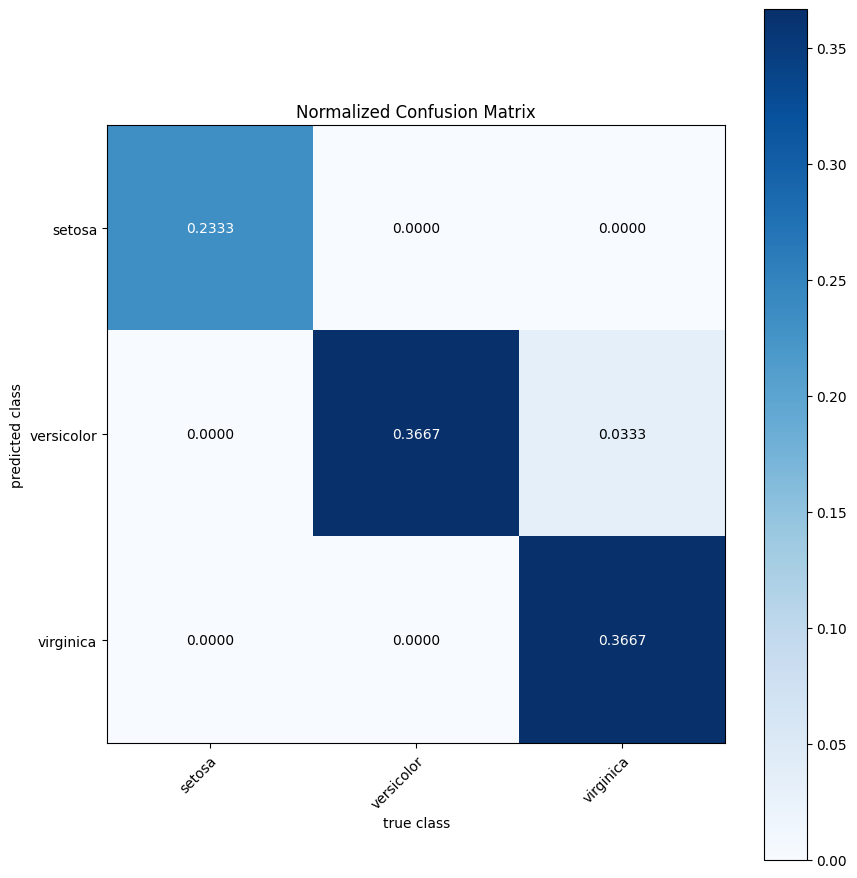

In [17]:
eval_stats.plot_confusion_matrix(normalize=True);

### Using the Fully-Integrated Evaluation Utilities

sensAI's evaluation utilities take things one step further and assist you in out all the evaluation steps and results computations in a single call.

You can perform evaluations based on a single split or cross-validation. We simply declare the necessary parameters for both types of computations (or the one type we seek to carry out).

In [18]:
evaluatorParams = sensai.evaluation.ClassificationEvaluatorParams(
    data_splitter=data_splitter, compute_probabilities=True,
    additional_metrics=[sensai.eval_stats_classification.ClassificationMetricTopNAccuracy(2)])
cross_validator_params = sensai.evaluation.crossval.VectorModelCrossValidatorParams(folds=10,
    evaluator_params=evaluator_params)
eval_util = sensai.evaluation.ClassificationModelEvaluation(iris_io_data,
    evaluator_params=evaluatorParams, cross_validator_params=cross_validator_params)

In practice, we will usually want to save evaluation results. The evaluation methods of `eval_util` take a parameter `result_writer` which allows us to define where results shall be written. Within this notebook, we shall simply inspect the resulting metrics in the log that is printed, and we shall configure plots to be shown directly.

#### Simple Evaluation

We can perform the same evaluation as above (which uses a single split) like so:

INFO  2024-11-29 18:24:25,193 sensai.evaluation.eval_util:perform_simple_evaluation:287 - Evaluating SkLearnRandomForestVectorClassificationModel[featureGenerator=None, rawInputTransformerChain=DataFrameTransformerChain[dataFrameTransformers=[]], featureTransformerChain=DataFrameTransformerChain[dataFrameTransformers=[]], fitArgs={}, useBalancedClassWeights=False, useLabelEncoding=False, name=RandomForest, model=RandomForestClassifier(min_samples_leaf=2, random_state=42)] via <sensai.evaluation.evaluator.VectorClassificationModelEvaluator object at 0x7fde42073820>


INFO  2024-11-29 18:24:25,194 sensai.vector_model:fit:359 - Fitting SkLearnRandomForestVectorClassificationModel instance


INFO  2024-11-29 18:24:25,195 sensai.sklearn.sklearn_base:_fit_classifier:314 - Fitting sklearn classifier of type RandomForestClassifier


INFO  2024-11-29 18:24:25,289 sensai.vector_model:fit:388 - Fitting completed in 0.09 seconds: SkLearnRandomForestVectorClassificationModel[featureGenerator=None, rawInputTransformerChain=DataFrameTransformerChain[dataFrameTransformers=[]], featureTransformerChain=DataFrameTransformerChain[dataFrameTransformers=[]], fitArgs={}, useBalancedClassWeights=False, useLabelEncoding=False, name=RandomForest, model=RandomForestClassifier(min_samples_leaf=2, random_state=42)]


INFO  2024-11-29 18:24:25,301 sensai.evaluation.eval_util:gather_results:295 - Evaluation results for class: ClassificationEvalStats[accuracy=0.9666666666666667, balancedAccuracy=0.9722222222222222, geoMeanTrueClassProb=0.8890980234758366, top2Accuracy=1.0, N=30]


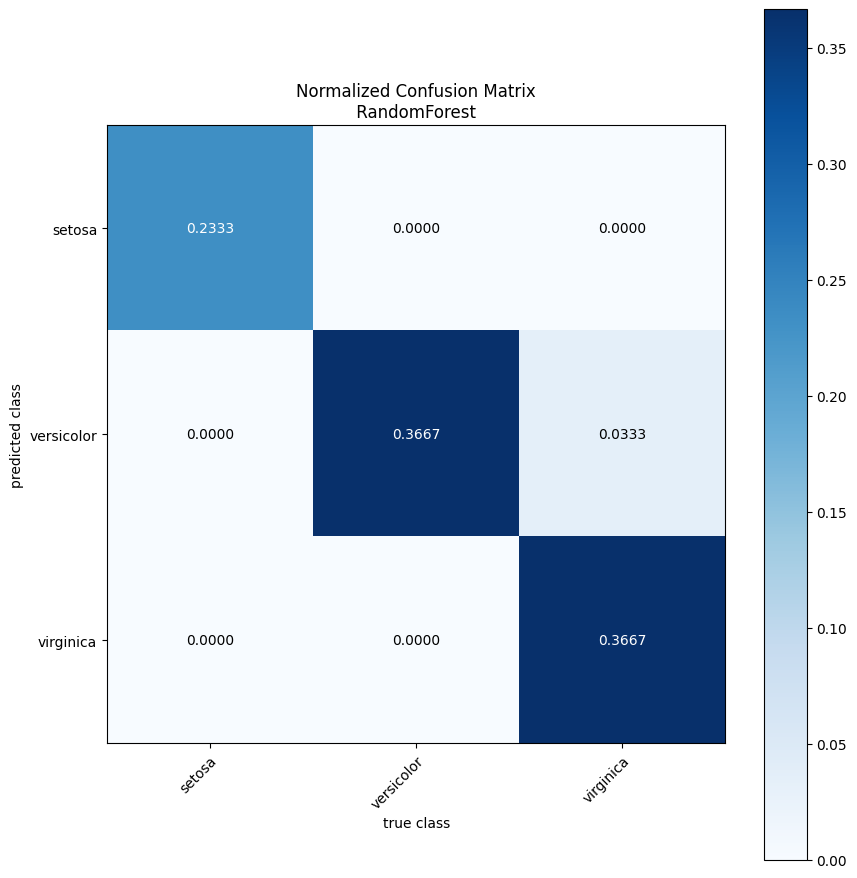

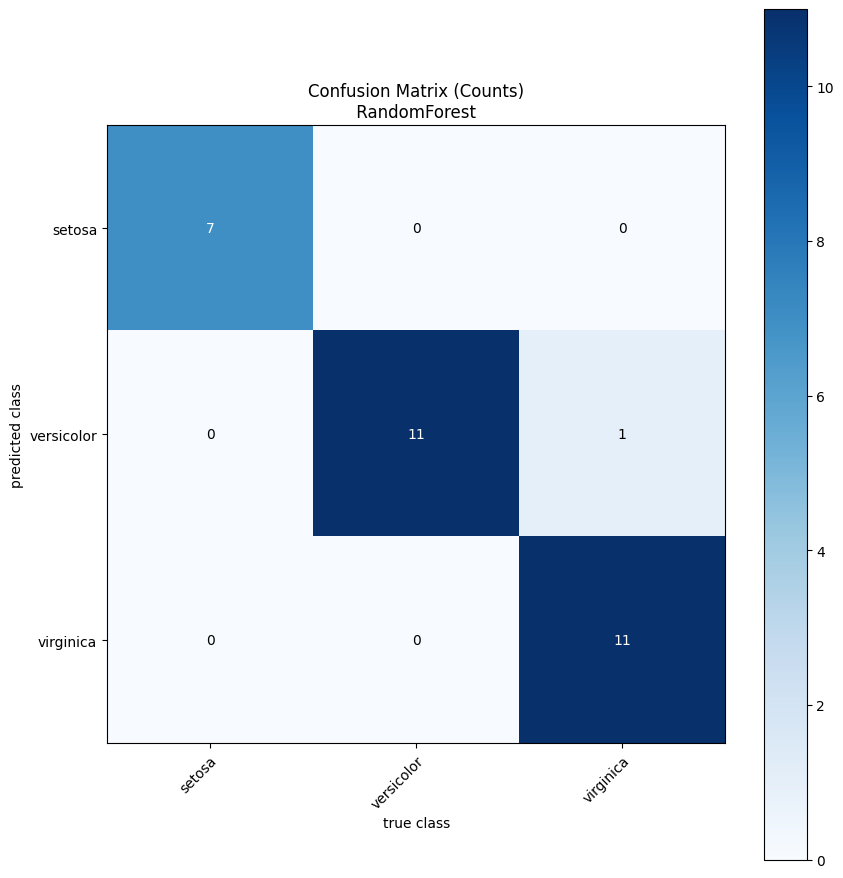

In [19]:
eval_util.perform_simple_evaluation(random_forest_model, show_plots=True)

#### Customising the Set of Plots

If we decide that we don't really want to have the normalised confusion matrix, we can disable it for any further experiments.

In [20]:
eval_util.eval_stats_plot_collector.get_enabled_plots()

['confusion-matrix-rel',
 'confusion-matrix-abs',
 'precision-recall',
 'threshold-precision-recall',
 'threshold-counts']

Some of these are only active for binary classification. The one we don't want is "confusion-matrix-rel".

In [21]:
eval_util.eval_stats_plot_collector.disable_plots("confusion-matrix-rel")

We could also define our own plot class (by creating a new subclass of `ClassificationEvalStatsPlot`) and add it to the plot collector in order to have the plot auto-generated whenever we apply one of `eval_util`'s methods.

#### Cross-Validation

We can similarly run cross-validation and produce the respective evaluation metrics with a single call.

INFO  2024-11-29 18:24:25,851 sensai.evaluation.crossval:eval_model:192 - Training and evaluating model with fold 1/10 ...


INFO  2024-11-29 18:24:25,852 sensai.vector_model:fit:359 - Fitting SkLearnRandomForestVectorClassificationModel instance


INFO  2024-11-29 18:24:25,853 sensai.sklearn.sklearn_base:_fit_classifier:314 - Fitting sklearn classifier of type RandomForestClassifier


INFO  2024-11-29 18:24:25,948 sensai.vector_model:fit:388 - Fitting completed in 0.09 seconds: SkLearnRandomForestVectorClassificationModel[featureGenerator=None, rawInputTransformerChain=DataFrameTransformerChain[dataFrameTransformers=[]], featureTransformerChain=DataFrameTransformerChain[dataFrameTransformers=[]], fitArgs={}, useBalancedClassWeights=False, useLabelEncoding=False, name=RandomForest, model=RandomForestClassifier(min_samples_leaf=2, random_state=42)]


INFO  2024-11-29 18:24:25,963 sensai.evaluation.crossval:eval_model:201 - Evaluation result for class, fold 1/10: ClassificationEvalStats[accuracy=1.0, balancedAccuracy=1.0, geoMeanTrueClassProb=0.9553599022560102, N=15]


INFO  2024-11-29 18:24:25,964 sensai.evaluation.crossval:eval_model:192 - Training and evaluating model with fold 2/10 ...


INFO  2024-11-29 18:24:25,965 sensai.vector_model:fit:359 - Fitting SkLearnRandomForestVectorClassificationModel instance


INFO  2024-11-29 18:24:25,966 sensai.sklearn.sklearn_base:_fit_classifier:314 - Fitting sklearn classifier of type RandomForestClassifier


INFO  2024-11-29 18:24:26,060 sensai.vector_model:fit:388 - Fitting completed in 0.09 seconds: SkLearnRandomForestVectorClassificationModel[featureGenerator=None, rawInputTransformerChain=DataFrameTransformerChain[dataFrameTransformers=[]], featureTransformerChain=DataFrameTransformerChain[dataFrameTransformers=[]], fitArgs={}, useBalancedClassWeights=False, useLabelEncoding=False, name=RandomForest, model=RandomForestClassifier(min_samples_leaf=2, random_state=42)]


INFO  2024-11-29 18:24:26,072 sensai.evaluation.crossval:eval_model:201 - Evaluation result for class, fold 2/10: ClassificationEvalStats[accuracy=1.0, balancedAccuracy=1.0, geoMeanTrueClassProb=0.9734228107223192, N=15]


INFO  2024-11-29 18:24:26,073 sensai.evaluation.crossval:eval_model:192 - Training and evaluating model with fold 3/10 ...


INFO  2024-11-29 18:24:26,073 sensai.vector_model:fit:359 - Fitting SkLearnRandomForestVectorClassificationModel instance


INFO  2024-11-29 18:24:26,075 sensai.sklearn.sklearn_base:_fit_classifier:314 - Fitting sklearn classifier of type RandomForestClassifier


INFO  2024-11-29 18:24:26,169 sensai.vector_model:fit:388 - Fitting completed in 0.09 seconds: SkLearnRandomForestVectorClassificationModel[featureGenerator=None, rawInputTransformerChain=DataFrameTransformerChain[dataFrameTransformers=[]], featureTransformerChain=DataFrameTransformerChain[dataFrameTransformers=[]], fitArgs={}, useBalancedClassWeights=False, useLabelEncoding=False, name=RandomForest, model=RandomForestClassifier(min_samples_leaf=2, random_state=42)]


INFO  2024-11-29 18:24:26,182 sensai.evaluation.crossval:eval_model:201 - Evaluation result for class, fold 3/10: ClassificationEvalStats[accuracy=1.0, balancedAccuracy=1.0, geoMeanTrueClassProb=0.976458969438705, N=15]


INFO  2024-11-29 18:24:26,182 sensai.evaluation.crossval:eval_model:192 - Training and evaluating model with fold 4/10 ...


INFO  2024-11-29 18:24:26,183 sensai.vector_model:fit:359 - Fitting SkLearnRandomForestVectorClassificationModel instance


INFO  2024-11-29 18:24:26,184 sensai.sklearn.sklearn_base:_fit_classifier:314 - Fitting sklearn classifier of type RandomForestClassifier


INFO  2024-11-29 18:24:26,278 sensai.vector_model:fit:388 - Fitting completed in 0.09 seconds: SkLearnRandomForestVectorClassificationModel[featureGenerator=None, rawInputTransformerChain=DataFrameTransformerChain[dataFrameTransformers=[]], featureTransformerChain=DataFrameTransformerChain[dataFrameTransformers=[]], fitArgs={}, useBalancedClassWeights=False, useLabelEncoding=False, name=RandomForest, model=RandomForestClassifier(min_samples_leaf=2, random_state=42)]


INFO  2024-11-29 18:24:26,289 sensai.evaluation.crossval:eval_model:201 - Evaluation result for class, fold 4/10: ClassificationEvalStats[accuracy=0.9333333333333333, balancedAccuracy=0.9333333333333332, geoMeanTrueClassProb=0.9411926691126593, N=15]


INFO  2024-11-29 18:24:26,289 sensai.evaluation.crossval:eval_model:192 - Training and evaluating model with fold 5/10 ...


INFO  2024-11-29 18:24:26,290 sensai.vector_model:fit:359 - Fitting SkLearnRandomForestVectorClassificationModel instance


INFO  2024-11-29 18:24:26,291 sensai.sklearn.sklearn_base:_fit_classifier:314 - Fitting sklearn classifier of type RandomForestClassifier


INFO  2024-11-29 18:24:26,385 sensai.vector_model:fit:388 - Fitting completed in 0.09 seconds: SkLearnRandomForestVectorClassificationModel[featureGenerator=None, rawInputTransformerChain=DataFrameTransformerChain[dataFrameTransformers=[]], featureTransformerChain=DataFrameTransformerChain[dataFrameTransformers=[]], fitArgs={}, useBalancedClassWeights=False, useLabelEncoding=False, name=RandomForest, model=RandomForestClassifier(min_samples_leaf=2, random_state=42)]


INFO  2024-11-29 18:24:26,398 sensai.evaluation.crossval:eval_model:201 - Evaluation result for class, fold 5/10: ClassificationEvalStats[accuracy=1.0, balancedAccuracy=1.0, geoMeanTrueClassProb=0.9298964965102043, N=15]


INFO  2024-11-29 18:24:26,399 sensai.evaluation.crossval:eval_model:192 - Training and evaluating model with fold 6/10 ...


INFO  2024-11-29 18:24:26,399 sensai.vector_model:fit:359 - Fitting SkLearnRandomForestVectorClassificationModel instance


INFO  2024-11-29 18:24:26,401 sensai.sklearn.sklearn_base:_fit_classifier:314 - Fitting sklearn classifier of type RandomForestClassifier


INFO  2024-11-29 18:24:26,495 sensai.vector_model:fit:388 - Fitting completed in 0.09 seconds: SkLearnRandomForestVectorClassificationModel[featureGenerator=None, rawInputTransformerChain=DataFrameTransformerChain[dataFrameTransformers=[]], featureTransformerChain=DataFrameTransformerChain[dataFrameTransformers=[]], fitArgs={}, useBalancedClassWeights=False, useLabelEncoding=False, name=RandomForest, model=RandomForestClassifier(min_samples_leaf=2, random_state=42)]


INFO  2024-11-29 18:24:26,508 sensai.evaluation.crossval:eval_model:201 - Evaluation result for class, fold 6/10: ClassificationEvalStats[accuracy=0.8666666666666667, balancedAccuracy=0.8888888888888888, geoMeanTrueClassProb=0.6379522029160006, N=15]


INFO  2024-11-29 18:24:26,509 sensai.evaluation.crossval:eval_model:192 - Training and evaluating model with fold 7/10 ...


INFO  2024-11-29 18:24:26,510 sensai.vector_model:fit:359 - Fitting SkLearnRandomForestVectorClassificationModel instance


INFO  2024-11-29 18:24:26,511 sensai.sklearn.sklearn_base:_fit_classifier:314 - Fitting sklearn classifier of type RandomForestClassifier


INFO  2024-11-29 18:24:26,605 sensai.vector_model:fit:388 - Fitting completed in 0.09 seconds: SkLearnRandomForestVectorClassificationModel[featureGenerator=None, rawInputTransformerChain=DataFrameTransformerChain[dataFrameTransformers=[]], featureTransformerChain=DataFrameTransformerChain[dataFrameTransformers=[]], fitArgs={}, useBalancedClassWeights=False, useLabelEncoding=False, name=RandomForest, model=RandomForestClassifier(min_samples_leaf=2, random_state=42)]


INFO  2024-11-29 18:24:26,616 sensai.evaluation.crossval:eval_model:201 - Evaluation result for class, fold 7/10: ClassificationEvalStats[accuracy=0.8666666666666667, balancedAccuracy=0.8611111111111112, geoMeanTrueClassProb=0.8099785263057822, N=15]


INFO  2024-11-29 18:24:26,617 sensai.evaluation.crossval:eval_model:192 - Training and evaluating model with fold 8/10 ...


INFO  2024-11-29 18:24:26,618 sensai.vector_model:fit:359 - Fitting SkLearnRandomForestVectorClassificationModel instance


INFO  2024-11-29 18:24:26,619 sensai.sklearn.sklearn_base:_fit_classifier:314 - Fitting sklearn classifier of type RandomForestClassifier


INFO  2024-11-29 18:24:26,714 sensai.vector_model:fit:388 - Fitting completed in 0.10 seconds: SkLearnRandomForestVectorClassificationModel[featureGenerator=None, rawInputTransformerChain=DataFrameTransformerChain[dataFrameTransformers=[]], featureTransformerChain=DataFrameTransformerChain[dataFrameTransformers=[]], fitArgs={}, useBalancedClassWeights=False, useLabelEncoding=False, name=RandomForest, model=RandomForestClassifier(min_samples_leaf=2, random_state=42)]


INFO  2024-11-29 18:24:26,726 sensai.evaluation.crossval:eval_model:201 - Evaluation result for class, fold 8/10: ClassificationEvalStats[accuracy=1.0, balancedAccuracy=1.0, geoMeanTrueClassProb=0.9657414983648998, N=15]


INFO  2024-11-29 18:24:26,726 sensai.evaluation.crossval:eval_model:192 - Training and evaluating model with fold 9/10 ...


INFO  2024-11-29 18:24:26,727 sensai.vector_model:fit:359 - Fitting SkLearnRandomForestVectorClassificationModel instance


INFO  2024-11-29 18:24:26,728 sensai.sklearn.sklearn_base:_fit_classifier:314 - Fitting sklearn classifier of type RandomForestClassifier


INFO  2024-11-29 18:24:26,822 sensai.vector_model:fit:388 - Fitting completed in 0.09 seconds: SkLearnRandomForestVectorClassificationModel[featureGenerator=None, rawInputTransformerChain=DataFrameTransformerChain[dataFrameTransformers=[]], featureTransformerChain=DataFrameTransformerChain[dataFrameTransformers=[]], fitArgs={}, useBalancedClassWeights=False, useLabelEncoding=False, name=RandomForest, model=RandomForestClassifier(min_samples_leaf=2, random_state=42)]


INFO  2024-11-29 18:24:26,837 sensai.evaluation.crossval:eval_model:201 - Evaluation result for class, fold 9/10: ClassificationEvalStats[accuracy=1.0, balancedAccuracy=1.0, geoMeanTrueClassProb=0.9560552426688266, N=15]


INFO  2024-11-29 18:24:26,837 sensai.evaluation.crossval:eval_model:192 - Training and evaluating model with fold 10/10 ...


INFO  2024-11-29 18:24:26,838 sensai.vector_model:fit:359 - Fitting SkLearnRandomForestVectorClassificationModel instance


INFO  2024-11-29 18:24:26,839 sensai.sklearn.sklearn_base:_fit_classifier:314 - Fitting sklearn classifier of type RandomForestClassifier


INFO  2024-11-29 18:24:26,933 sensai.vector_model:fit:388 - Fitting completed in 0.09 seconds: SkLearnRandomForestVectorClassificationModel[featureGenerator=None, rawInputTransformerChain=DataFrameTransformerChain[dataFrameTransformers=[]], featureTransformerChain=DataFrameTransformerChain[dataFrameTransformers=[]], fitArgs={}, useBalancedClassWeights=False, useLabelEncoding=False, name=RandomForest, model=RandomForestClassifier(min_samples_leaf=2, random_state=42)]


INFO  2024-11-29 18:24:26,944 sensai.evaluation.crossval:eval_model:201 - Evaluation result for class, fold 10/10: ClassificationEvalStats[accuracy=0.9333333333333333, balancedAccuracy=0.9523809523809524, geoMeanTrueClassProb=0.841736920530503, N=15]


INFO  2024-11-29 18:24:26,958 sensai.evaluation.eval_util:perform_cross_validation:350 - Cross-validation results:
       mean[accuracy]  std[accuracy]  mean[balancedAccuracy]  std[balancedAccuracy]  mean[geoMeanTrueClassProb]  std[geoMeanTrueClassProb]
class            0.96       0.053333                0.963571               0.050077                     0.89878                    0.10223


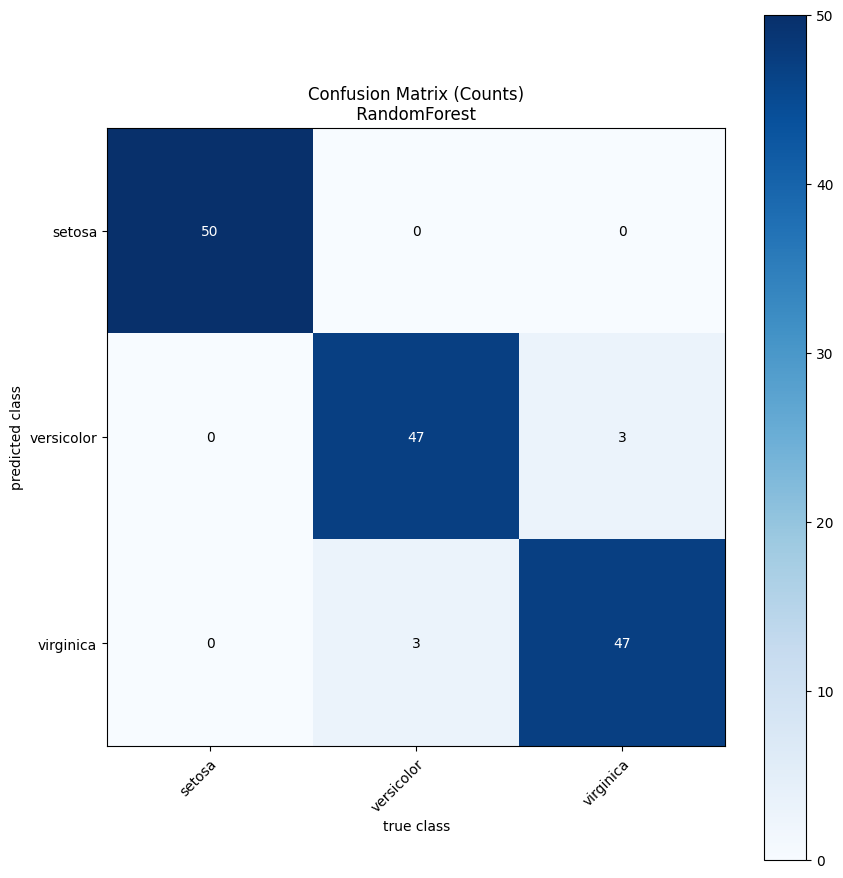

In [22]:
eval_util.perform_cross_validation(random_forest_model, show_plots=True)

As you can see, the plot we disabled earlier is no longer being generated.

#### Comparing Models

A most common use case is to compare the performance of several models. The evaluation utility makes it very simple to compare any number of models.

Let's say we want to compare the random forest we have been using thus far to a simple decision tree.

In [23]:
results = eval_util.compare_models([
        random_forest_model,
        sensai.sklearn.classification.SkLearnDecisionTreeVectorClassificationModel(min_samples_leaf=2).with_name("DecisionTree")],
    use_cross_validation=True)

INFO  2024-11-29 18:24:27,223 sensai.evaluation.eval_util:compare_models:399 - Evaluating model 1/2 named 'RandomForest' ...


INFO  2024-11-29 18:24:27,227 sensai.evaluation.crossval:eval_model:192 - Training and evaluating model with fold 1/10 ...


INFO  2024-11-29 18:24:27,228 sensai.vector_model:fit:359 - Fitting SkLearnRandomForestVectorClassificationModel instance


INFO  2024-11-29 18:24:27,229 sensai.sklearn.sklearn_base:_fit_classifier:314 - Fitting sklearn classifier of type RandomForestClassifier


INFO  2024-11-29 18:24:27,322 sensai.vector_model:fit:388 - Fitting completed in 0.09 seconds: SkLearnRandomForestVectorClassificationModel[featureGenerator=None, rawInputTransformerChain=DataFrameTransformerChain[dataFrameTransformers=[]], featureTransformerChain=DataFrameTransformerChain[dataFrameTransformers=[]], fitArgs={}, useBalancedClassWeights=False, useLabelEncoding=False, name=RandomForest, model=RandomForestClassifier(min_samples_leaf=2, random_state=42)]


INFO  2024-11-29 18:24:27,337 sensai.evaluation.crossval:eval_model:201 - Evaluation result for class, fold 1/10: ClassificationEvalStats[accuracy=1.0, balancedAccuracy=1.0, geoMeanTrueClassProb=0.9553599022560102, N=15]


INFO  2024-11-29 18:24:27,337 sensai.evaluation.crossval:eval_model:192 - Training and evaluating model with fold 2/10 ...


INFO  2024-11-29 18:24:27,338 sensai.vector_model:fit:359 - Fitting SkLearnRandomForestVectorClassificationModel instance


INFO  2024-11-29 18:24:27,339 sensai.sklearn.sklearn_base:_fit_classifier:314 - Fitting sklearn classifier of type RandomForestClassifier


INFO  2024-11-29 18:24:27,433 sensai.vector_model:fit:388 - Fitting completed in 0.09 seconds: SkLearnRandomForestVectorClassificationModel[featureGenerator=None, rawInputTransformerChain=DataFrameTransformerChain[dataFrameTransformers=[]], featureTransformerChain=DataFrameTransformerChain[dataFrameTransformers=[]], fitArgs={}, useBalancedClassWeights=False, useLabelEncoding=False, name=RandomForest, model=RandomForestClassifier(min_samples_leaf=2, random_state=42)]


INFO  2024-11-29 18:24:27,446 sensai.evaluation.crossval:eval_model:201 - Evaluation result for class, fold 2/10: ClassificationEvalStats[accuracy=1.0, balancedAccuracy=1.0, geoMeanTrueClassProb=0.9734228107223192, N=15]


INFO  2024-11-29 18:24:27,447 sensai.evaluation.crossval:eval_model:192 - Training and evaluating model with fold 3/10 ...


INFO  2024-11-29 18:24:27,448 sensai.vector_model:fit:359 - Fitting SkLearnRandomForestVectorClassificationModel instance


INFO  2024-11-29 18:24:27,449 sensai.sklearn.sklearn_base:_fit_classifier:314 - Fitting sklearn classifier of type RandomForestClassifier


INFO  2024-11-29 18:24:27,546 sensai.vector_model:fit:388 - Fitting completed in 0.10 seconds: SkLearnRandomForestVectorClassificationModel[featureGenerator=None, rawInputTransformerChain=DataFrameTransformerChain[dataFrameTransformers=[]], featureTransformerChain=DataFrameTransformerChain[dataFrameTransformers=[]], fitArgs={}, useBalancedClassWeights=False, useLabelEncoding=False, name=RandomForest, model=RandomForestClassifier(min_samples_leaf=2, random_state=42)]


INFO  2024-11-29 18:24:27,559 sensai.evaluation.crossval:eval_model:201 - Evaluation result for class, fold 3/10: ClassificationEvalStats[accuracy=1.0, balancedAccuracy=1.0, geoMeanTrueClassProb=0.976458969438705, N=15]


INFO  2024-11-29 18:24:27,560 sensai.evaluation.crossval:eval_model:192 - Training and evaluating model with fold 4/10 ...


INFO  2024-11-29 18:24:27,560 sensai.vector_model:fit:359 - Fitting SkLearnRandomForestVectorClassificationModel instance


INFO  2024-11-29 18:24:27,561 sensai.sklearn.sklearn_base:_fit_classifier:314 - Fitting sklearn classifier of type RandomForestClassifier


INFO  2024-11-29 18:24:27,657 sensai.vector_model:fit:388 - Fitting completed in 0.10 seconds: SkLearnRandomForestVectorClassificationModel[featureGenerator=None, rawInputTransformerChain=DataFrameTransformerChain[dataFrameTransformers=[]], featureTransformerChain=DataFrameTransformerChain[dataFrameTransformers=[]], fitArgs={}, useBalancedClassWeights=False, useLabelEncoding=False, name=RandomForest, model=RandomForestClassifier(min_samples_leaf=2, random_state=42)]


INFO  2024-11-29 18:24:27,669 sensai.evaluation.crossval:eval_model:201 - Evaluation result for class, fold 4/10: ClassificationEvalStats[accuracy=0.9333333333333333, balancedAccuracy=0.9333333333333332, geoMeanTrueClassProb=0.9411926691126593, N=15]


INFO  2024-11-29 18:24:27,670 sensai.evaluation.crossval:eval_model:192 - Training and evaluating model with fold 5/10 ...


INFO  2024-11-29 18:24:27,670 sensai.vector_model:fit:359 - Fitting SkLearnRandomForestVectorClassificationModel instance


INFO  2024-11-29 18:24:27,672 sensai.sklearn.sklearn_base:_fit_classifier:314 - Fitting sklearn classifier of type RandomForestClassifier


INFO  2024-11-29 18:24:27,770 sensai.vector_model:fit:388 - Fitting completed in 0.10 seconds: SkLearnRandomForestVectorClassificationModel[featureGenerator=None, rawInputTransformerChain=DataFrameTransformerChain[dataFrameTransformers=[]], featureTransformerChain=DataFrameTransformerChain[dataFrameTransformers=[]], fitArgs={}, useBalancedClassWeights=False, useLabelEncoding=False, name=RandomForest, model=RandomForestClassifier(min_samples_leaf=2, random_state=42)]


INFO  2024-11-29 18:24:27,782 sensai.evaluation.crossval:eval_model:201 - Evaluation result for class, fold 5/10: ClassificationEvalStats[accuracy=1.0, balancedAccuracy=1.0, geoMeanTrueClassProb=0.9298964965102043, N=15]


INFO  2024-11-29 18:24:27,783 sensai.evaluation.crossval:eval_model:192 - Training and evaluating model with fold 6/10 ...


INFO  2024-11-29 18:24:27,784 sensai.vector_model:fit:359 - Fitting SkLearnRandomForestVectorClassificationModel instance


INFO  2024-11-29 18:24:27,785 sensai.sklearn.sklearn_base:_fit_classifier:314 - Fitting sklearn classifier of type RandomForestClassifier


INFO  2024-11-29 18:24:27,885 sensai.vector_model:fit:388 - Fitting completed in 0.10 seconds: SkLearnRandomForestVectorClassificationModel[featureGenerator=None, rawInputTransformerChain=DataFrameTransformerChain[dataFrameTransformers=[]], featureTransformerChain=DataFrameTransformerChain[dataFrameTransformers=[]], fitArgs={}, useBalancedClassWeights=False, useLabelEncoding=False, name=RandomForest, model=RandomForestClassifier(min_samples_leaf=2, random_state=42)]


INFO  2024-11-29 18:24:27,898 sensai.evaluation.crossval:eval_model:201 - Evaluation result for class, fold 6/10: ClassificationEvalStats[accuracy=0.8666666666666667, balancedAccuracy=0.8888888888888888, geoMeanTrueClassProb=0.6379522029160006, N=15]


INFO  2024-11-29 18:24:27,899 sensai.evaluation.crossval:eval_model:192 - Training and evaluating model with fold 7/10 ...


INFO  2024-11-29 18:24:27,899 sensai.vector_model:fit:359 - Fitting SkLearnRandomForestVectorClassificationModel instance


INFO  2024-11-29 18:24:27,900 sensai.sklearn.sklearn_base:_fit_classifier:314 - Fitting sklearn classifier of type RandomForestClassifier


INFO  2024-11-29 18:24:28,003 sensai.vector_model:fit:388 - Fitting completed in 0.10 seconds: SkLearnRandomForestVectorClassificationModel[featureGenerator=None, rawInputTransformerChain=DataFrameTransformerChain[dataFrameTransformers=[]], featureTransformerChain=DataFrameTransformerChain[dataFrameTransformers=[]], fitArgs={}, useBalancedClassWeights=False, useLabelEncoding=False, name=RandomForest, model=RandomForestClassifier(min_samples_leaf=2, random_state=42)]


INFO  2024-11-29 18:24:28,014 sensai.evaluation.crossval:eval_model:201 - Evaluation result for class, fold 7/10: ClassificationEvalStats[accuracy=0.8666666666666667, balancedAccuracy=0.8611111111111112, geoMeanTrueClassProb=0.8099785263057822, N=15]


INFO  2024-11-29 18:24:28,015 sensai.evaluation.crossval:eval_model:192 - Training and evaluating model with fold 8/10 ...


INFO  2024-11-29 18:24:28,015 sensai.vector_model:fit:359 - Fitting SkLearnRandomForestVectorClassificationModel instance


INFO  2024-11-29 18:24:28,017 sensai.sklearn.sklearn_base:_fit_classifier:314 - Fitting sklearn classifier of type RandomForestClassifier


INFO  2024-11-29 18:24:28,117 sensai.vector_model:fit:388 - Fitting completed in 0.10 seconds: SkLearnRandomForestVectorClassificationModel[featureGenerator=None, rawInputTransformerChain=DataFrameTransformerChain[dataFrameTransformers=[]], featureTransformerChain=DataFrameTransformerChain[dataFrameTransformers=[]], fitArgs={}, useBalancedClassWeights=False, useLabelEncoding=False, name=RandomForest, model=RandomForestClassifier(min_samples_leaf=2, random_state=42)]


INFO  2024-11-29 18:24:28,133 sensai.evaluation.crossval:eval_model:201 - Evaluation result for class, fold 8/10: ClassificationEvalStats[accuracy=1.0, balancedAccuracy=1.0, geoMeanTrueClassProb=0.9657414983648998, N=15]


INFO  2024-11-29 18:24:28,133 sensai.evaluation.crossval:eval_model:192 - Training and evaluating model with fold 9/10 ...


INFO  2024-11-29 18:24:28,134 sensai.vector_model:fit:359 - Fitting SkLearnRandomForestVectorClassificationModel instance


INFO  2024-11-29 18:24:28,135 sensai.sklearn.sklearn_base:_fit_classifier:314 - Fitting sklearn classifier of type RandomForestClassifier


INFO  2024-11-29 18:24:28,232 sensai.vector_model:fit:388 - Fitting completed in 0.10 seconds: SkLearnRandomForestVectorClassificationModel[featureGenerator=None, rawInputTransformerChain=DataFrameTransformerChain[dataFrameTransformers=[]], featureTransformerChain=DataFrameTransformerChain[dataFrameTransformers=[]], fitArgs={}, useBalancedClassWeights=False, useLabelEncoding=False, name=RandomForest, model=RandomForestClassifier(min_samples_leaf=2, random_state=42)]


INFO  2024-11-29 18:24:28,246 sensai.evaluation.crossval:eval_model:201 - Evaluation result for class, fold 9/10: ClassificationEvalStats[accuracy=1.0, balancedAccuracy=1.0, geoMeanTrueClassProb=0.9560552426688266, N=15]


INFO  2024-11-29 18:24:28,247 sensai.evaluation.crossval:eval_model:192 - Training and evaluating model with fold 10/10 ...


INFO  2024-11-29 18:24:28,247 sensai.vector_model:fit:359 - Fitting SkLearnRandomForestVectorClassificationModel instance


INFO  2024-11-29 18:24:28,249 sensai.sklearn.sklearn_base:_fit_classifier:314 - Fitting sklearn classifier of type RandomForestClassifier


INFO  2024-11-29 18:24:28,342 sensai.vector_model:fit:388 - Fitting completed in 0.09 seconds: SkLearnRandomForestVectorClassificationModel[featureGenerator=None, rawInputTransformerChain=DataFrameTransformerChain[dataFrameTransformers=[]], featureTransformerChain=DataFrameTransformerChain[dataFrameTransformers=[]], fitArgs={}, useBalancedClassWeights=False, useLabelEncoding=False, name=RandomForest, model=RandomForestClassifier(min_samples_leaf=2, random_state=42)]


INFO  2024-11-29 18:24:28,354 sensai.evaluation.crossval:eval_model:201 - Evaluation result for class, fold 10/10: ClassificationEvalStats[accuracy=0.9333333333333333, balancedAccuracy=0.9523809523809524, geoMeanTrueClassProb=0.841736920530503, N=15]


INFO  2024-11-29 18:24:28,368 sensai.evaluation.eval_util:perform_cross_validation:350 - Cross-validation results:
       mean[accuracy]  std[accuracy]  mean[balancedAccuracy]  std[balancedAccuracy]  mean[geoMeanTrueClassProb]  std[geoMeanTrueClassProb]
class            0.96       0.053333                0.963571               0.050077                     0.89878                    0.10223


INFO  2024-11-29 18:24:28,451 sensai.evaluation.eval_util:compare_models:399 - Evaluating model 2/2 named 'DecisionTree' ...


INFO  2024-11-29 18:24:28,452 sensai.evaluation.crossval:eval_model:192 - Training and evaluating model with fold 1/10 ...


INFO  2024-11-29 18:24:28,453 sensai.vector_model:fit:359 - Fitting SkLearnDecisionTreeVectorClassificationModel instance


INFO  2024-11-29 18:24:28,454 sensai.sklearn.sklearn_base:_fit_classifier:314 - Fitting sklearn classifier of type DecisionTreeClassifier


INFO  2024-11-29 18:24:28,457 sensai.vector_model:fit:388 - Fitting completed in 0.00 seconds: SkLearnDecisionTreeVectorClassificationModel[featureGenerator=None, rawInputTransformerChain=DataFrameTransformerChain[dataFrameTransformers=[]], featureTransformerChain=DataFrameTransformerChain[dataFrameTransformers=[]], fitArgs={}, useBalancedClassWeights=False, useLabelEncoding=False, name=DecisionTree, model=DecisionTreeClassifier(min_samples_leaf=2, random_state=42)]


INFO  2024-11-29 18:24:28,464 sensai.evaluation.crossval:eval_model:201 - Evaluation result for class, fold 1/10: ClassificationEvalStats[accuracy=1.0, balancedAccuracy=1.0, geoMeanTrueClassProb=1.0, N=15]


INFO  2024-11-29 18:24:28,465 sensai.evaluation.crossval:eval_model:192 - Training and evaluating model with fold 2/10 ...


INFO  2024-11-29 18:24:28,466 sensai.vector_model:fit:359 - Fitting SkLearnDecisionTreeVectorClassificationModel instance


INFO  2024-11-29 18:24:28,467 sensai.sklearn.sklearn_base:_fit_classifier:314 - Fitting sklearn classifier of type DecisionTreeClassifier


INFO  2024-11-29 18:24:28,470 sensai.vector_model:fit:388 - Fitting completed in 0.00 seconds: SkLearnDecisionTreeVectorClassificationModel[featureGenerator=None, rawInputTransformerChain=DataFrameTransformerChain[dataFrameTransformers=[]], featureTransformerChain=DataFrameTransformerChain[dataFrameTransformers=[]], fitArgs={}, useBalancedClassWeights=False, useLabelEncoding=False, name=DecisionTree, model=DecisionTreeClassifier(min_samples_leaf=2, random_state=42)]


INFO  2024-11-29 18:24:28,477 sensai.evaluation.crossval:eval_model:201 - Evaluation result for class, fold 2/10: ClassificationEvalStats[accuracy=1.0, balancedAccuracy=1.0, geoMeanTrueClassProb=1.0, N=15]


INFO  2024-11-29 18:24:28,477 sensai.evaluation.crossval:eval_model:192 - Training and evaluating model with fold 3/10 ...


INFO  2024-11-29 18:24:28,478 sensai.vector_model:fit:359 - Fitting SkLearnDecisionTreeVectorClassificationModel instance


INFO  2024-11-29 18:24:28,479 sensai.sklearn.sklearn_base:_fit_classifier:314 - Fitting sklearn classifier of type DecisionTreeClassifier


INFO  2024-11-29 18:24:28,482 sensai.vector_model:fit:388 - Fitting completed in 0.00 seconds: SkLearnDecisionTreeVectorClassificationModel[featureGenerator=None, rawInputTransformerChain=DataFrameTransformerChain[dataFrameTransformers=[]], featureTransformerChain=DataFrameTransformerChain[dataFrameTransformers=[]], fitArgs={}, useBalancedClassWeights=False, useLabelEncoding=False, name=DecisionTree, model=DecisionTreeClassifier(min_samples_leaf=2, random_state=42)]


INFO  2024-11-29 18:24:28,489 sensai.evaluation.crossval:eval_model:201 - Evaluation result for class, fold 3/10: ClassificationEvalStats[accuracy=1.0, balancedAccuracy=1.0, geoMeanTrueClassProb=1.0, N=15]


INFO  2024-11-29 18:24:28,489 sensai.evaluation.crossval:eval_model:192 - Training and evaluating model with fold 4/10 ...


INFO  2024-11-29 18:24:28,490 sensai.vector_model:fit:359 - Fitting SkLearnDecisionTreeVectorClassificationModel instance


INFO  2024-11-29 18:24:28,492 sensai.sklearn.sklearn_base:_fit_classifier:314 - Fitting sklearn classifier of type DecisionTreeClassifier


INFO  2024-11-29 18:24:28,495 sensai.vector_model:fit:388 - Fitting completed in 0.00 seconds: SkLearnDecisionTreeVectorClassificationModel[featureGenerator=None, rawInputTransformerChain=DataFrameTransformerChain[dataFrameTransformers=[]], featureTransformerChain=DataFrameTransformerChain[dataFrameTransformers=[]], fitArgs={}, useBalancedClassWeights=False, useLabelEncoding=False, name=DecisionTree, model=DecisionTreeClassifier(min_samples_leaf=2, random_state=42)]


INFO  2024-11-29 18:24:28,502 sensai.evaluation.crossval:eval_model:201 - Evaluation result for class, fold 4/10: ClassificationEvalStats[accuracy=0.9333333333333333, balancedAccuracy=0.9333333333333332, geoMeanTrueClassProb=0.6141303814089187, N=15]


INFO  2024-11-29 18:24:28,502 sensai.evaluation.crossval:eval_model:192 - Training and evaluating model with fold 5/10 ...


INFO  2024-11-29 18:24:28,503 sensai.vector_model:fit:359 - Fitting SkLearnDecisionTreeVectorClassificationModel instance


INFO  2024-11-29 18:24:28,504 sensai.sklearn.sklearn_base:_fit_classifier:314 - Fitting sklearn classifier of type DecisionTreeClassifier


INFO  2024-11-29 18:24:28,507 sensai.vector_model:fit:388 - Fitting completed in 0.00 seconds: SkLearnDecisionTreeVectorClassificationModel[featureGenerator=None, rawInputTransformerChain=DataFrameTransformerChain[dataFrameTransformers=[]], featureTransformerChain=DataFrameTransformerChain[dataFrameTransformers=[]], fitArgs={}, useBalancedClassWeights=False, useLabelEncoding=False, name=DecisionTree, model=DecisionTreeClassifier(min_samples_leaf=2, random_state=42)]


INFO  2024-11-29 18:24:28,514 sensai.evaluation.crossval:eval_model:201 - Evaluation result for class, fold 5/10: ClassificationEvalStats[accuracy=0.9333333333333333, balancedAccuracy=0.9333333333333332, geoMeanTrueClassProb=0.9548416039104165, N=15]


INFO  2024-11-29 18:24:28,515 sensai.evaluation.crossval:eval_model:192 - Training and evaluating model with fold 6/10 ...


INFO  2024-11-29 18:24:28,515 sensai.vector_model:fit:359 - Fitting SkLearnDecisionTreeVectorClassificationModel instance


INFO  2024-11-29 18:24:28,516 sensai.sklearn.sklearn_base:_fit_classifier:314 - Fitting sklearn classifier of type DecisionTreeClassifier


INFO  2024-11-29 18:24:28,520 sensai.vector_model:fit:388 - Fitting completed in 0.00 seconds: SkLearnDecisionTreeVectorClassificationModel[featureGenerator=None, rawInputTransformerChain=DataFrameTransformerChain[dataFrameTransformers=[]], featureTransformerChain=DataFrameTransformerChain[dataFrameTransformers=[]], fitArgs={}, useBalancedClassWeights=False, useLabelEncoding=False, name=DecisionTree, model=DecisionTreeClassifier(min_samples_leaf=2, random_state=42)]


INFO  2024-11-29 18:24:28,526 sensai.evaluation.crossval:eval_model:201 - Evaluation result for class, fold 6/10: ClassificationEvalStats[accuracy=0.8666666666666667, balancedAccuracy=0.8888888888888888, geoMeanTrueClassProb=0.39810717055349726, N=15]


INFO  2024-11-29 18:24:28,527 sensai.evaluation.crossval:eval_model:192 - Training and evaluating model with fold 7/10 ...


INFO  2024-11-29 18:24:28,528 sensai.vector_model:fit:359 - Fitting SkLearnDecisionTreeVectorClassificationModel instance


INFO  2024-11-29 18:24:28,529 sensai.sklearn.sklearn_base:_fit_classifier:314 - Fitting sklearn classifier of type DecisionTreeClassifier


INFO  2024-11-29 18:24:28,532 sensai.vector_model:fit:388 - Fitting completed in 0.00 seconds: SkLearnDecisionTreeVectorClassificationModel[featureGenerator=None, rawInputTransformerChain=DataFrameTransformerChain[dataFrameTransformers=[]], featureTransformerChain=DataFrameTransformerChain[dataFrameTransformers=[]], fitArgs={}, useBalancedClassWeights=False, useLabelEncoding=False, name=DecisionTree, model=DecisionTreeClassifier(min_samples_leaf=2, random_state=42)]


INFO  2024-11-29 18:24:28,539 sensai.evaluation.crossval:eval_model:201 - Evaluation result for class, fold 7/10: ClassificationEvalStats[accuracy=0.8666666666666667, balancedAccuracy=0.8611111111111112, geoMeanTrueClassProb=0.39810717055349726, N=15]


INFO  2024-11-29 18:24:28,539 sensai.evaluation.crossval:eval_model:192 - Training and evaluating model with fold 8/10 ...


INFO  2024-11-29 18:24:28,540 sensai.vector_model:fit:359 - Fitting SkLearnDecisionTreeVectorClassificationModel instance


INFO  2024-11-29 18:24:28,542 sensai.sklearn.sklearn_base:_fit_classifier:314 - Fitting sklearn classifier of type DecisionTreeClassifier


INFO  2024-11-29 18:24:28,545 sensai.vector_model:fit:388 - Fitting completed in 0.00 seconds: SkLearnDecisionTreeVectorClassificationModel[featureGenerator=None, rawInputTransformerChain=DataFrameTransformerChain[dataFrameTransformers=[]], featureTransformerChain=DataFrameTransformerChain[dataFrameTransformers=[]], fitArgs={}, useBalancedClassWeights=False, useLabelEncoding=False, name=DecisionTree, model=DecisionTreeClassifier(min_samples_leaf=2, random_state=42)]


INFO  2024-11-29 18:24:28,551 sensai.evaluation.crossval:eval_model:201 - Evaluation result for class, fold 8/10: ClassificationEvalStats[accuracy=0.9333333333333333, balancedAccuracy=0.9444444444444445, geoMeanTrueClassProb=0.9548416039104165, N=15]


INFO  2024-11-29 18:24:28,552 sensai.evaluation.crossval:eval_model:192 - Training and evaluating model with fold 9/10 ...


INFO  2024-11-29 18:24:28,552 sensai.vector_model:fit:359 - Fitting SkLearnDecisionTreeVectorClassificationModel instance


INFO  2024-11-29 18:24:28,553 sensai.sklearn.sklearn_base:_fit_classifier:314 - Fitting sklearn classifier of type DecisionTreeClassifier


INFO  2024-11-29 18:24:28,556 sensai.vector_model:fit:388 - Fitting completed in 0.00 seconds: SkLearnDecisionTreeVectorClassificationModel[featureGenerator=None, rawInputTransformerChain=DataFrameTransformerChain[dataFrameTransformers=[]], featureTransformerChain=DataFrameTransformerChain[dataFrameTransformers=[]], fitArgs={}, useBalancedClassWeights=False, useLabelEncoding=False, name=DecisionTree, model=DecisionTreeClassifier(min_samples_leaf=2, random_state=42)]


INFO  2024-11-29 18:24:28,562 sensai.evaluation.crossval:eval_model:201 - Evaluation result for class, fold 9/10: ClassificationEvalStats[accuracy=0.9333333333333333, balancedAccuracy=0.9333333333333332, geoMeanTrueClassProb=0.6141303814089187, N=15]


INFO  2024-11-29 18:24:28,563 sensai.evaluation.crossval:eval_model:192 - Training and evaluating model with fold 10/10 ...


INFO  2024-11-29 18:24:28,563 sensai.vector_model:fit:359 - Fitting SkLearnDecisionTreeVectorClassificationModel instance


INFO  2024-11-29 18:24:28,564 sensai.sklearn.sklearn_base:_fit_classifier:314 - Fitting sklearn classifier of type DecisionTreeClassifier


INFO  2024-11-29 18:24:28,567 sensai.vector_model:fit:388 - Fitting completed in 0.00 seconds: SkLearnDecisionTreeVectorClassificationModel[featureGenerator=None, rawInputTransformerChain=DataFrameTransformerChain[dataFrameTransformers=[]], featureTransformerChain=DataFrameTransformerChain[dataFrameTransformers=[]], fitArgs={}, useBalancedClassWeights=False, useLabelEncoding=False, name=DecisionTree, model=DecisionTreeClassifier(min_samples_leaf=2, random_state=42)]


INFO  2024-11-29 18:24:28,573 sensai.evaluation.crossval:eval_model:201 - Evaluation result for class, fold 10/10: ClassificationEvalStats[accuracy=0.9333333333333333, balancedAccuracy=0.9523809523809524, geoMeanTrueClassProb=0.6309573444801932, N=15]


INFO  2024-11-29 18:24:28,587 sensai.evaluation.eval_util:perform_cross_validation:350 - Cross-validation results:
       mean[accuracy]  std[accuracy]  mean[balancedAccuracy]  std[balancedAccuracy]  mean[geoMeanTrueClassProb]  std[geoMeanTrueClassProb]
class            0.94       0.046667                0.944683                0.04441                    0.756512                   0.238693


INFO  2024-11-29 18:24:28,685 sensai.evaluation.eval_util:compare_models:468 - Model comparison results, aggregated across folds:
              mean[accuracy]  std[accuracy]  mean[balancedAccuracy]  std[balancedAccuracy]  mean[geoMeanTrueClassProb]  std[geoMeanTrueClassProb]
model_name                                                                                                                                       
RandomForest            0.96       0.053333                0.963571               0.050077                    0.898780                   0.102230
DecisionTree            0.94       0.046667                0.944683               0.044410                    0.756512                   0.238693


In addition to the data frame with the aggregated metrics, which was already printed to the log, the results object contains all the data that was generated during the evaluation. We can, for example, use it to plot the distribution of one of the metrics across all the folds for one of our models.

,mean[accuracy],std[accuracy],mean[balancedAccuracy],std[balancedAccuracy],mean[geoMeanTrueClassProb],std[geoMeanTrueClassProb]
model_name,,,,,,
RandomForest,0.96,0.053333,0.963571,0.050077,0.898780,0.102230
DecisionTree,0.94,0.046667,0.944683,0.044410,0.756512,0.238693


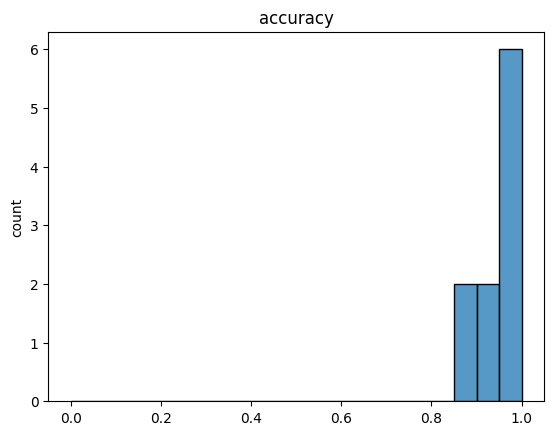

In [24]:
display(results.results_df)

esc_random_forest = results.result_by_model_name["RandomForest"].cross_validation_data.get_eval_stats_collection()
esc_random_forest.plot_distribution("accuracy", bins=np.linspace(0,1,21), stat="count", kde=False);


We can also compute additional aggregations or inspect the full list of metrics.

In [25]:
esc_random_forest.agg_metrics_dict(agg_fns=[np.max, np.min])

{'amax[accuracy]': 1.0,
 'amin[accuracy]': 0.8666666666666667,
 'amax[balancedAccuracy]': 1.0,
 'amin[balancedAccuracy]': 0.8611111111111112,
 'amax[geoMeanTrueClassProb]': 0.976458969438705,
 'amin[geoMeanTrueClassProb]': 0.6379522029160006}

In [26]:
esc_random_forest.get_values("accuracy")

[1.0,
 1.0,
 1.0,
 0.9333333333333333,
 1.0,
 0.8666666666666667,
 0.8666666666666667,
 1.0,
 1.0,
 0.9333333333333333]

## Feature Generators and Data Frame Transformers

When dealing with the preparation of input data for a model, we often need to cater to technical requirements of various types of models. sensAI seeks to make the process of supporting multiple input pipelines for different types of models as simple as possible - by focusing on concise, declarative semantics and integrating the model-specific data extraction and transformation mechanisms into the models themselves.
In essence, this means:

  1. **Starting with the raw or most general representation of the data**
 
     This could mean simply starting with the data that is straightforward for us to obtain - or using directly using particular domain specific objects.
     
     For example, if the problem is to classify situations, we might already have a ``Situation`` class in our code which represents all the data that is is relevant to a situation (e.g. the point in time, the affected user, the location, etc.). Pandas DataFrames can represent arbitrary data, so there is no reason to not simply use as the raw input data frame that is fed to our models a single column containing instances of class ``Situation``.
     Or we might instead directly observe a set of sensor readings, all of which are real numbers; this scenario would certainly be closer to what we typically see in machine learning data sets, but it isn't always the case in the real world.
     
     Whatever the case may be, we can represent it in a data frame. We call the original input data frame, which we pass to a sensAI ``VectorModel``, the *raw data frame*.

  2. **Extracing features from the raw data, using their "natural" representation** (using ``FeatureGenerators``)
     
     We extract from the raw data frame pieces of information that we regard as relevant *features* for the task at hand.
     A sensAI ``FeatureGenerator`` can generate one or more data frame columns (containing arbitrary data), and a model can be associated with any number of feature generators.
     Several key aspects:

       * FeatureGenerators crititcally decouple the original raw data from the features used by the models, enabling different models to use different sets of features or 
         entirely different representations of the same features.
       * FeatureGenerators become part of the model and are (where necessary) jointly trained with model. This facilitates model deployment, as every sensAI model becomes a single unit
         that can directly process raw input data, which is (usually) straightforward to supply at inference time.
       * FeatureGenerators store meta-data on the features they generate, enabling downstream components to handle them appropriately.

     The feature representation that we choose to generate can be arbitrary, but oftentimes, we will want to extract "natural" feature representations, which could, in priciple, be used by many types of models, albeit in different concrete forms.
     Sequential data can be naturally represented as an array/list, categorical data can be represented using descriptive category names, and numeric data can be represented using 
     unmodified integers and floating point numbers.

  3. **Transforming feature representations into a form that is suitable for the model at hand** (using ``DataFrameTransformers``)
     
     In the transformation stage, we address the model-specific idiosynchrasies, which may require, for example, that all features be represented as numbers (or even numbers within a limited range) or
     that all features be discrete, that no values be missing, etc.
     A ``DataFrameTransformer`` can, in principle perform an arbitary transformation from one data frame to another, but the typical use case is to apply transformations of feature representations that
     are necessary for specific types of models to work (their best).

     


     